In [1]:
import tensorflow as tf
from tensorflow import keras
# from tensorflow.keras import layer

from tensorflow.keras import initializers
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import optimizers

from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Input, BatchNormalization, LeakyReLU, Dense, Reshape, Flatten, Activation 
from tensorflow.keras.layers import Dropout, multiply, GaussianNoise, MaxPooling2D, concatenate

2022-09-30 15:11:35.728186: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [2]:
import collections
import sys, os, datetime

import numpy as np
import matplotlib.pyplot as plt
import pickle
import pandas as pd

from sklearn.metrics import roc_curve, auc,precision_recall_fscore_support, average_precision_score
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve, auc, confusion_matrix,accuracy_score, plot_confusion_matrix

import seaborn as sns
import tensorboard

from tqdm import tqdm

import helper_functions

pd.options.display.max_columns = None

In [3]:
filename = '../data/preprocessed_data.pickle'
figure_path = '../report/best/autoencoder/'

input_file = open(filename,'rb')
preprocessed_data = pickle.load(input_file)
input_file.close()

In [4]:
le = preprocessed_data['le']
x_train = preprocessed_data['x_train']
y_train = preprocessed_data['y_train']
x_test = preprocessed_data['x_test']
y_test = preprocessed_data['y_test']

In [5]:
scaler = MinMaxScaler()

x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

x_train = x_train.astype(np.float32)
x_test = x_test.astype(np.float32)

In [6]:
def convert_label_to_binary(label_encoder, labels):
    normal_idx = np.where(label_encoder.classes_ == 'BENIGN')[0]
    my_labels = labels.copy()
    my_labels[my_labels != normal_idx] = 1 
    my_labels[my_labels == normal_idx] = 0
    return my_labels

In [7]:
y_train = convert_label_to_binary(le, y_train)
y_test = convert_label_to_binary(le, y_test)
# add the binary labels to our anomaly dataframe

In [8]:
y_test

array([0, 0, 0, ..., 0, 0, 1])

In [9]:
x_train

array([[1.2207218e-03, 3.9295829e-04, 9.1009197e-06, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [7.8899825e-01, 1.3333332e-07, 4.5504598e-06, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [8.2742047e-01, 7.9999995e-07, 0.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       ...,
       [1.2207218e-03, 8.1188965e-01, 2.7302760e-05, ..., 0.0000000e+00,
        8.1166667e-01, 8.1166667e-01],
       [8.0872816e-04, 8.4505824e-04, 4.5504598e-06, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [1.2207218e-03, 1.2213415e-03, 9.1009197e-06, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00]], dtype=float32)

In [10]:
input_dim = x_train.shape[1]

batch_size = 512
latent_dim = 4 
max_epochs = 100 

In [11]:
input_data = Input(shape=(input_dim,), name='encoder_input')

encoder = Dense(96,activation='tanh', name='encoder_1')(input_data)
encoder = Dropout(.1)(encoder)
encoder = Dense(64,activation='tanh', name='encoder_2')(encoder)
encoder = Dropout(.1)(encoder)
encoder = Dense(48,activation='tanh', name='encoder_3')(encoder)
encoder = Dropout(.1)(encoder)
encoder = Dense(16,activation='tanh', name='encoder_4')(encoder)
encoder = Dropout(.1)(encoder)

latent_encoding = Dense(latent_dim, activation='linear', name='latent_encoding')(encoder)

encoder_model = Model(input_data, latent_encoding)


2022-09-30 15:11:40.300839: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-09-30 15:11:40.301430: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-09-30 15:11:40.328424: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-30 15:11:40.328600: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:25:00.0 name: NVIDIA GeForce GTX 1060 6GB computeCapability: 6.1
coreClock: 1.7335GHz coreCount: 10 deviceMemorySize: 5.93GiB deviceMemoryBandwidth: 178.99GiB/s
2022-09-30 15:11:40.328613: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2022-09-30 15:11:40.329771: I tensorflow/stream_executor/platfo

In [12]:
decoder = Dense(16, activation='tanh', name='decoder_1')(latent_encoding)
decoder = Dropout(.1)(decoder)
decoder = Dense(48, activation='tanh', name='decoder_2')(decoder)
decoder = Dropout(.1)(decoder)
decoder = Dense(64, activation='tanh', name='decoder_3')(decoder)
decoder = Dropout(.1)(decoder)
decoder = Dense(96, activation='tanh', name='decoder_4')(decoder)
decoder = Dropout(.1)(decoder)

reconstructed_data = Dense(input_dim, activation='linear', name='reconstructed_data')(decoder)

In [13]:
autoencoder_model = Model(input_data, reconstructed_data)

In [14]:
autoencoder_model.count_params()

35602

In [15]:
opt = optimizers.Adam(lr=.00001)

autoencoder_model.compile(optimizer=opt, loss = 'mse', metrics=['accuracy'])

In [16]:
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, profile_batch=0, update_freq='epoch', histogram_freq=1)

train_history = autoencoder_model.fit(x_train, x_train,
        shuffle=False,
        epochs=max_epochs,
        batch_size=batch_size,
        validation_data=(x_test, x_test),
        callbacks=[tensorboard_callback])

2022-09-30 15:11:41.003801: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 661722984 exceeds 10% of free system memory.
2022-09-30 15:11:42.151740: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 661722984 exceeds 10% of free system memory.
2022-09-30 15:11:43.539372: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-09-30 15:11:43.554895: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 3601570000 Hz


Epoch 1/100
  16/4143 [..............................] - ETA: 13s - loss: 0.0871 - accuracy: 0.0120  

2022-09-30 15:11:43.942970: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10


4132/4143 [============================>.] - ETA: 0s - loss: 0.0467 - accuracy: 0.0425

2022-09-30 15:11:53.729944: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 220574328 exceeds 10% of free system memory.
2022-09-30 15:11:53.865105: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 220574328 exceeds 10% of free system memory.


4143/4143 [==============================] - 12s 3ms/step - loss: 0.0467 - accuracy: 0.0426 - val_loss: 0.0083 - val_accuracy: 5.6580e-06
Epoch 2/100
4143/4143 [==============================] - 11s 3ms/step - loss: 0.0126 - accuracy: 0.0926 - val_loss: 0.0054 - val_accuracy: 0.0724
Epoch 3/100
4143/4143 [==============================] - 11s 3ms/step - loss: 0.0082 - accuracy: 0.1687 - val_loss: 0.0047 - val_accuracy: 0.1064
Epoch 4/100
4143/4143 [==============================] - 11s 3ms/step - loss: 0.0069 - accuracy: 0.2042 - val_loss: 0.0046 - val_accuracy: 0.1127
Epoch 5/100
4143/4143 [==============================] - 11s 3ms/step - loss: 0.0064 - accuracy: 0.2204 - val_loss: 0.0046 - val_accuracy: 0.1212
Epoch 6/100
4143/4143 [==============================] - 11s 3ms/step - loss: 0.0061 - accuracy: 0.2298 - val_loss: 0.0046 - val_accuracy: 0.4607
Epoch 7/100
4143/4143 [==============================] - 12s 3ms/step - loss: 0.0060 - accuracy: 0.2356 - val_loss: 0.0045 - val_acc

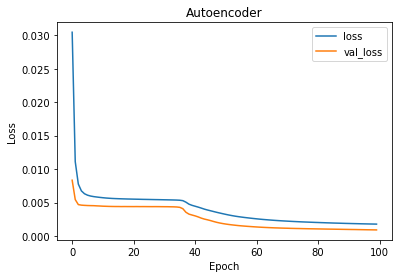

In [17]:
helper_functions.plot_loss(train_history, figure_path + 'loss_autoencoder.png', 'Autoencoder')

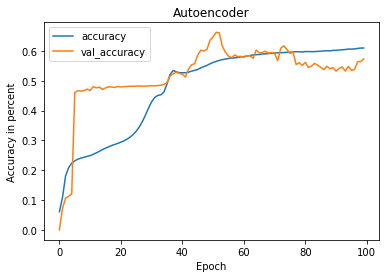

In [18]:
helper_functions.plot_accuracy(train_history, figure_path + 'accuracy_autoencoder.png', 'Autoencoder')

In [19]:
x_test_recon = autoencoder_model.predict(x_test)
reconstruction_scores = np.mean((x_test - x_test_recon)**2, axis=1)
anomaly_data = pd.DataFrame({'recon_score':reconstruction_scores})

2022-09-30 15:30:44.011784: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 220574328 exceeds 10% of free system memory.


<AxesSubplot:ylabel='Frequency'>

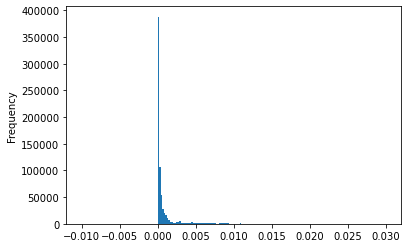

In [20]:
anomaly_data['recon_score'].plot.hist(bins=200, range=[-.01, .03])

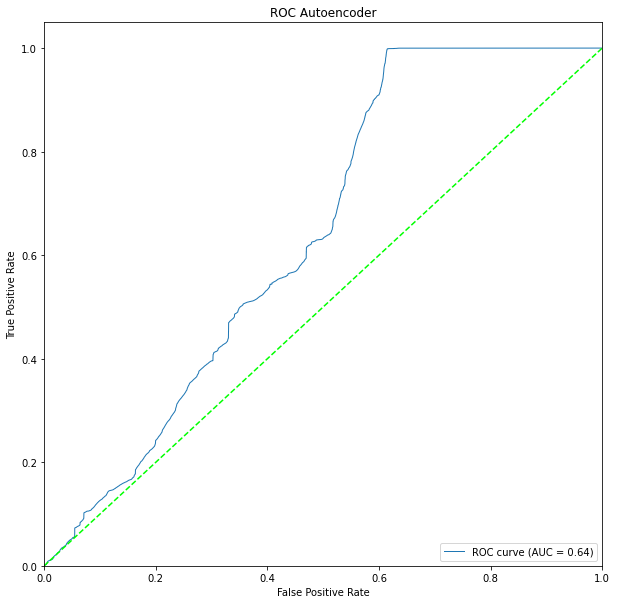

In [21]:
fpr, tpr, thresholds = roc_curve(y_test, reconstruction_scores)
roc_auc = auc(fpr, tpr)

helper_functions.plot_roc(tpr, fpr, roc_auc, figure_path + 'roc_autoencoder.png', 'Autoencoder')

In [22]:
threshold_idx = np.argmax(tpr - fpr)
threshold = thresholds[threshold_idx]
print(threshold)

3.188081e-05


In [23]:
pred_labels = (reconstruction_scores > threshold).astype(int)

results = confusion_matrix(y_test, pred_labels) 
precision, recall, f1, _ = precision_recall_fscore_support(y_test, pred_labels, average='binary')
print('Accuracy Score :', accuracy_score(y_test, pred_labels))
print('Precision :', precision)
print('Recall :', recall)
print('F1 :', f1)

Accuracy Score : 0.5059910689153273
Precision : 0.2850887433386174
Recall : 0.9986727219244814
F1 : 0.4435564690230942


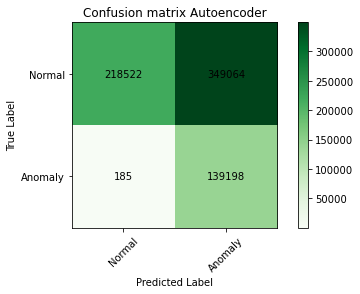

In [24]:
helper_functions.plot_confusion_matrix(results, figure_path + 'confusion_autoencoder.png', 'Autoencoder')